In [1]:
import time
from pyspark.sql import SparkSession

app_name = 'Dataset_papandas'

conf = {
    # Настройки спарк-сессии на основании возможностей виртуальной машины
    'spark.dynamicAllocation.enabled': 'true',
	'spark.shuffle.service.enabled': 'true',
    'spark.dynamicAllocation.maxExecutors': 3,
    'spark.executor.memory': '3g',
    'spark.executor.cores': '4',
    'spark.driver.memory': '4g',
}

builder = (
    SparkSession
    .builder
    .appName(app_name)
)

for k, v in conf.items():
    builder.config(k, v)

spark = builder.getOrCreate()

In [2]:
# При финальном оформлении отчета появилась проблема с доступом к виртуальной машине, поэтому значения
# в данном ноутбуке получены на локально установленном датасете из 113 млн строк
# Датасет: https://www.kaggle.com/datasets/zanjibar/100-million-data-csv
data = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(r"path_to_your_file.csv")
)

data.printSchema()

root
 |-- 198801: integer (nullable = true)
 |-- 1: integer (nullable = true)
 |-- 103: integer (nullable = true)
 |-- 100: integer (nullable = true)
 |-- 000000190: integer (nullable = true)
 |-- 0: long (nullable = true)
 |-- 35843: integer (nullable = true)
 |-- 34353: integer (nullable = true)



In [3]:
# Количество строк в датасете
row = data.count()
print(row)

113607321


# Сортировка

In [4]:
# По возрастанию
column = input()
start_time = time.time()
sorted_data_asc = data.orderBy(column)
sorted_data_asc.select(column, "your extra columns").show(15)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

198801
+------+
|198801|
+------+
|198801|
|198801|
|198801|
|198801|
|198801|
|198801|
|198801|
|198801|
|198801|
|198801|
|198801|
|198801|
|198801|
|198801|
|198801|
+------+
only showing top 15 rows

32.20311522483826


In [5]:
# По убыванию
column = input()
start_time = time.time()
sorted_data_dsc = data.orderBy(column, ascending = False)
sorted_data_dsc.select(column, "your extra columns").show(15)
end_time = time.time()
elapsed= start_time - end_time
print(elapsed_time)

198801
+------+
|198801|
+------+
|202012|
|202012|
|202012|
|202012|
|202012|
|202012|
|202012|
|202012|
|202012|
|202012|
|202012|
|202012|
|202012|
|202012|
|202012|
+------+
only showing top 15 rows

32.20311522483826


# Фильтрация

In [7]:
import pyspark.sql.functions as F

In [8]:
start_time = time.time()
filtered_data = data.filter(F.col("your_column") > "your_meaning")
filtered_data.select("your_column", "your_extra_columns").show()
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

+------+---+
|198801|  1|
+------+---+
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
|200001|  1|
+------+---+
only showing top 20 rows

13.74057412147522


# Статистика

In [9]:
column = input()
start_time = time.time()
statistics = data.agg(
    F.mean(column).alias("mean"),
    F.max(column).alias("max"),
    F.min(column).alias("min"),
    F.count(column).alias("count"),
    F.median(column).alias("median")
)
statistics.show()
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

198801
+------------------+------+------+---------+--------+
|              mean|   max|   min|    count|  median|
+------------------+------+------+---------+--------+
|200512.62317676694|202012|198801|113607321|200511.0|
+------------------+------+------+---------+--------+

37.6389365196228


In [10]:
# Перцентили
column = input()
start_time = time.time()
percentiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
print(percentiles)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

198801
[199709.0, 200511.0, 201307.0]
39.2353994846344


# Настройка спарк-сессии

Ключевыми параметрами в настройке спарк-сессии являются:
    1) driver.memory
    2) executor.cores
    3) executor.memory 
    4) dynamicAllocation.maxExecutors
Значения данных параметров для наиболее эффективной работы с датасетом были получены опытным путем с учетом возможностей
виртуальной машины (полученная виртуальная машина обладала 8 ядрами и 12 Гб свободной памяти). Дадим описание каждому параметру
и расскажем, почему мы выбрали те или иные значения.
    1) Параметр driver.memory определяет объем памяти, выделенной драйверу приложения. Если драйверу не хватает памяти, это может привести к ошибкам OutOfMemory и сбоям приложения. Параметр не влияет существенным образом на скорость работы, поэтому
он был принят равным 4Гб для стабильной работы с датасетом на 100 млн строк
    2) Параметр executor.cores указывает на то, сколько ядер процессора будет выделено каждому исполнителю. Увеличение числа ядер повышает параллелизм, но слишком много ядер может вызвать конфликты и ухудшить производительность. Поэтому для виртуальной машины будет наиболее оптимально использовать 6 или 7 ядер для наиболее быстрой работы.
    3) Параметр executor.memory отвечает за то, сколько памяти будет отведено для работы каждому экзекьютору. Для максимального 
задействования ресурсов на виртуальной машине было принято использовать 2Гб на каждом экзекьюторе, т.к. при 6 ядрах и 12 Гб свободной памяти это даст наиболее высокую скорость.
    4) Параметр dynamicAllocation.maxExecutors определяет максимальное количество рабочих экзекьюторов, опытным путем было 
определено, что наиболее быстрое время работы достигается при количестве на 1 меньше количества установленных в пункте 2 ядер 
(в нашем случае dynamicAllocation.maxExecutors = 5)

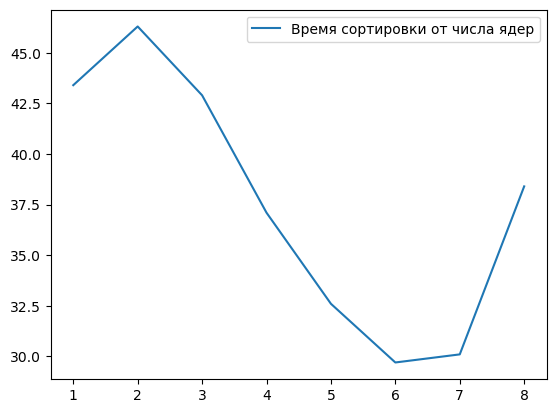

In [11]:
# Зависимости времени сортировки от различных параметров
# Здесь и далее неизменяемые значения равны driver.memory = 4g, executor.cores = 6, executor.memory = 2g, maxExecutors = 5
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'executor.cores': [1, 2, 3, 4, 5, 6, 7, 8],
                   'sorting_time':  [43.4, 46.3, 42.9, 37.1, 32.6, 29.7, 30.1, 38.4]})

plt.plot(df['executor.cores'], df['sorting_time'], label = "Время сортировки от числа ядер")
plt.legend()
plt.show()

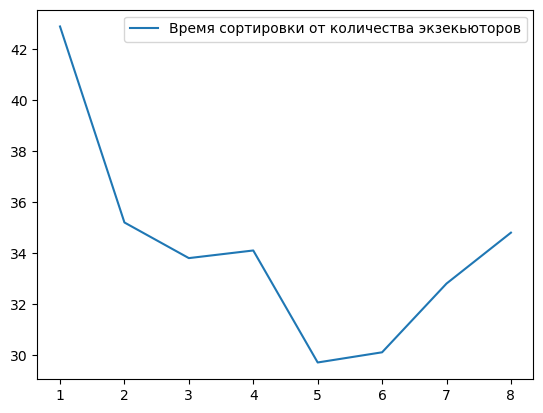

In [12]:
df = pd.DataFrame({'maxExecutors': [1, 2, 3, 4, 5, 6, 7, 8],
                   'sorting_time':  [42.9, 35.2, 33.8, 34.1, 29.7, 30.1, 32.8, 34.8]})

plt.plot(df['maxExecutors'], df['sorting_time'], label = "Время сортировки от количества экзекьюторов")
plt.legend()
plt.show()

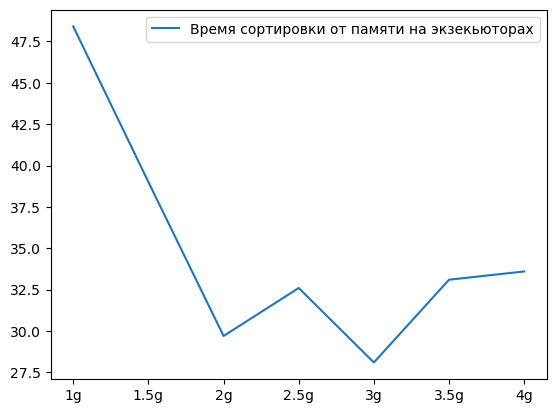

In [13]:
df = pd.DataFrame({'executor.memory': ['1g', '1.5g', '2g', '2.5g', '3g', '3.5g', '4g'],
                   'sorting_time':  [48.4, 39.0, 29.7, 32.6, 28.1, 33.1, 33.6]})

plt.plot(df['executor.memory'], df['sorting_time'], label = "Время сортировки от памяти на экзекьюторах")
plt.legend()
plt.show()

Графики времени фильтрации и рассчета статистик выглядят также, с учетом сдвига на константу. Таким образом на виртуальной
машине удалось достичь таких значений: 
    1) Сортировка: 29,7 сек
    2) Фильтрация: 11,4 сек
    3) Статистика: 32,6 сек
    4) Перцентили: 34,4 сек

# Выводы

Встроенные методы фреймворка Spark позволяют проводить быстрые манипуляции с большими объемами данных 
(намного быстрее, чем pandas, во многих случаях он остается единственным способом для проведения анализа), с помощью
них легко проводить сортировку, фильтрацию, рассчет различных статистических показателей. Для наиболее быстрой работы
требуется проводить настройку спарк-сессии для эффективного использования ресурсов, что и было продимонстрированно выше 
в нашей работе. В ходе проделанного проекта удалось установить потимальные параметры спарк-сессии для работы с большим 
датафреймом, а также проведена работа со внутренними функциями фреймворка spark.